# GD(CV) Project : ResNet Ablation Study

|평가문항|상세기준|
|:---|:---|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

## 0) 라이브러리 버전 확인하기

In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from keras.layers import ZeroPadding2D, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D, Input, Add, Activation
from keras import layers

import urllib3
urllib3.disable_warnings()


## 1) ResNet 기본 블록 구성하기
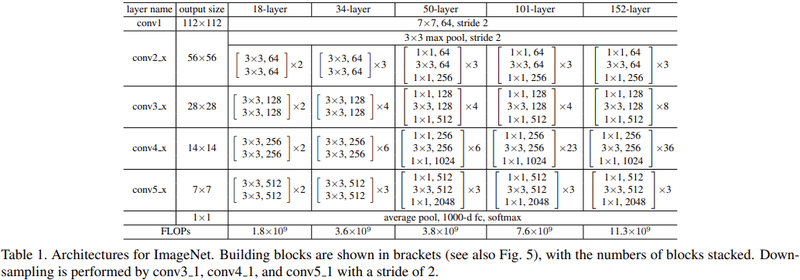

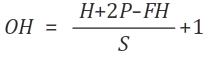

- 정사각형 이미지를 쓰기 때문에 OH = OW (각 Height, Width)
- P = Padding, FH = Filter Height, S = Stride를 의미한다.
- 논문에서 CIFAR-10의 32x32 이미지에 대해서는 맨 첫 convolution filter를 3x3이 좋다고 언급. 그럴 경우 (32+2P-3)/2 +1 = 16.
- 차원만 맞추면 성립하기 때문에 방법은 여러가지. 위 예시처럼 할 수도 있고 Conv(2,2), stride = 2로 사용할 수도 있다.

#### ResNet 구조에 대한 Memo
-  "We adopt batchnormalization (BN) right after each convolution and before activation, following ." Convolution 뒤는 항상 Batchnormalization layer가 따라온다. -> Conv_block을 만들기.
- BN과 Activation 위치는 여러 관점이 있다. 아래 링크에서는 Ablation Study를 통한 결과로 BN은 Add 뒤에 나오면 test결과에 심각한 성능 저하를 보인다. 
- 심지어 Relu를 블록 끝에서 제거하는 것이 약간의 성능을 높인다고도 한다. 하지만 그 값이 미미하기 때문에 좀 더 실험이 필요하다고 결론을 지었다.

resnet 구조 및 ablation study한 결과에 대한 설명:
http://torch.ch/blog/2016/02/04/resnets.html

res50의 구조:
http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006



In [4]:
def conv_block(input_layer,
               channel,
               kernel_size,
               strides=1,
              #  block_num=0,
              #  cnn_num=0,
               padding='same',
               activation='relu',
               ):
  
  x = Conv2D(
            filters=channel,
            kernel_size=kernel_size,
            kernel_initializer='he_normal',
            padding=padding,
            strides=strides
            )(input_layer)

  x = BatchNormalization()(x)

  if activation:
    x = Activation(activation)(x)
  return x


#### relu의 위치 및 첫 shortcut 차이

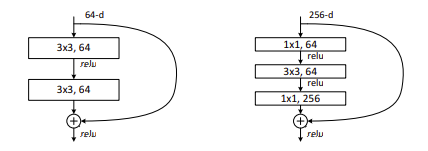

#### Residual Network에 대한 Memo
- res34은 block - 0에서는 conv(1,1) shortcut을 쓰지 않고 바로 identity를 사용. block - 1부터는 conv(1,1) 사용.
- res50은 맨 처음 conv block이 시작될 때 channel * 4를 하여 conv(1,1) shortcut을 사용하지만 stride는 (1,1)
- relu는 Add 후에 적용.
- 모든 shortcut을 (1,1)으로 쓰는 것이 성능상 좋지만 약간의 차이고, identity shortcut을 통해서 모델의 복잡성을 증가시키지 않고, 메모리나 시간 축소 등의 이점이 더 많기 때문에 섞어 사용하는 방법을 채택한다.

In [5]:
def build_resnet_block(input_layer,
                 num_cnn=3,
                 channel=64,
                 block_num=0,
                 is_50=True):
  x = input_layer

# ResNet - 50
  if is_50:
      for i in range(num_cnn):
        if block_num == 0 and i == 0:
            shortcut = conv_block(x, channel*4, (1,1), strides=1, padding='valid', activation=None)
            x = conv_block(x, channel, (1, 1), strides=1, padding='valid')
            x = conv_block(x, channel, (3, 3), strides=1)
            x = conv_block(x, channel*4, (1, 1), strides=1, padding='valid', activation=None)
        elif block_num > 0 and i == 0:
            shortcut = conv_block(x, channel*4, (1,1), strides=2, padding='valid', activation=None)
            x = conv_block(x, channel, (1, 1), strides=2, padding='valid')
            x = conv_block(x, channel, (3, 3), strides=1)
            x = conv_block(x, channel*4, (1, 1), strides=1,padding='valid', activation=None)       
        else:
            shortcut = x
            x = conv_block(x, channel, (1, 1), strides=1,padding='valid')
            x = conv_block(x, channel, (3, 3), strides=1)
            x = conv_block(x, channel*4, (1, 1), strides=1,padding='valid', activation=None)
        
        x = Add()([x, shortcut])
        x = Activation('relu')(x)

  # ResNet - 34
  else:
      for i in range(num_cnn):
        if block_num > 0 and i == 0:
            shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
            x = conv_block(x, channel, (3, 3), strides=2)
            x = conv_block(x, channel, (3, 3), activation=None)
        else:
            shortcut = x
            x = conv_block(x, channel, (3,3))
            x = conv_block(x, channel, (3,3), activation=None)
          
        x = Add()([x,shortcut])
        x = Activation('relu')(x)

  return x


## 2) ResNet-34, ResNet-50 Complete Model

In [6]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10,
                 is_50=True,
                 activation='softmax',
                 name='ResNet_50'
                 ):
    assert len(num_cnn_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)

    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x,
                              num_cnn=num_cnn, 
                              channel=channel, 
                              block_num=block_num, 
                              is_50=is_50
                              )

    x = GlobalAveragePooling2D()(x)
    x = Flatten(name='flatten')(x)
    x = Dense(num_classes, 
              activation=activation, 
              kernel_initializer='he_normal',
              name='fc10'
              )(x)

    model = keras.Model(inputs=input_layer,
                        outputs=x,
                        name=name
                        )
    
    return model


In [12]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50 = False)
resnet_34.summary()
# summary viewer link : https://drive.google.com/file/d/1_EkQWJaA_Lq53PXP3VkPhdaBzVbR0YUi/view?usp=sharing

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_108 (Conv2D)            (None, 16, 16, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_108 (Batch  (None, 16, 16, 64)  256         ['conv2d_108[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_99 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_108

In [13]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_144 (Conv2D)            (None, 16, 16, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 batch_normalization_144 (Batch  (None, 16, 16, 64)  256         ['conv2d_144[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_132 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_144

## 3) 일반 네트워크(plain network) 만들기

In [7]:
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [8]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

In [9]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

## 4) 데이터 불러오기 및 전처리
- cats_vs_dogs dataset

In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=('train[:80%]', 'train[80%:]'),
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete9QBTMN/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [11]:
ds_info.features["label"].num_classes

2

In [12]:
ds_info.features["label"].names

['cat', 'dog']

In [13]:
train_num = tf.data.experimental.cardinality(ds_train).numpy()
test_num = tf.data.experimental.cardinality(ds_test).numpy()
print(train_num)
print(test_num)

18610
4652


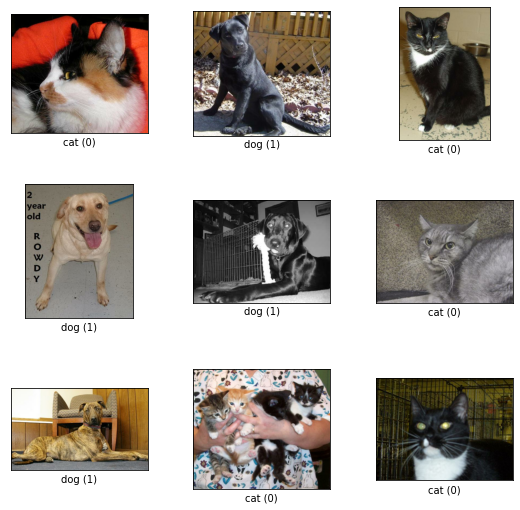

In [24]:
fig = tfds.show_examples(ds_train, ds_info)

In [14]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [16]:
BATCH_SIZE = 64
EPOCH = 10

In [17]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [18]:
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## 5) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
- ResNet-34,50 모델 224 사이즈로 다시 만들어주기.
- Plain-34,50과 ResNet-34,50 모두 각각 훈련해주기.
- 10epoch, 64batchsize (논문과 다름.)
-  We use SGD with a mini-batch size of 256. The learning rate starts from 0.1 and is divided by 10 when the error plateaus,and the models are trained for up to 60 × 104 iterations. We use a weight decay of 0.0001 and a momentum of 0.9.
- 위를 참고하여, hyper parameter 조정했는데, tf.keras.optimizer.SGD에는 decay 값이 존재하지 않음. epoch 수가 적기 때문에 lr은 0.1로 시작할 수 없기에 VGG 때와 같은 0.01로 두었다. 결국 Momentum 값만 적용해보았다.
- loss는 binary cross entropy를 사용했다.

In [19]:
resnet_34 = build_resnet(input_shape=(224, 224, 3),                                
                               num_classes=1, 
                               is_50=False, 
                               activation='sigmoid', 
                               name='ResNet_34')

resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

In [20]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(train_num/BATCH_SIZE),
    validation_steps=int(test_num/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


290/290 [==============================] - 97s 236ms/step - loss: 0.6943 - accuracy: 0.5559 - val_loss: 0.8571 - val_accuracy: 0.5221
Epoch 2/10
290/290 [==============================] - 64s 221ms/step - loss: 0.6276 - accuracy: 0.6432 - val_loss: 0.9022 - val_accuracy: 0.5874
Epoch 3/10
290/290 [==============================] - 64s 222ms/step - loss: 0.5497 - accuracy: 0.7252 - val_loss: 8.2622 - val_accuracy: 0.5125
Epoch 4/10
290/290 [==============================] - 64s 222ms/step - loss: 0.4778 - accuracy: 0.7702 - val_loss: 0.9108 - val_accuracy: 0.6240
Epoch 5/10
290/290 [==============================] - 64s 223ms/step - loss: 0.4195 - accuracy: 0.8040 - val_loss: 0.7004 - val_accuracy: 0.6764
Epoch 6/10
290/290 [==============================] - 64s 222ms/step - loss: 0.3674 - accuracy: 0.8374 - val_loss: 0.5961 - val_accuracy: 0.7025
Epoch 7/10
290/290 [==============================] - 65s 224ms/step - loss: 0.3038 - accuracy: 0.8655 - val_loss: 0.9385 - val_accuracy: 0.6

In [21]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(train_num/BATCH_SIZE),
    validation_steps=int(test_num/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


290/290 [==============================] - 86s 234ms/step - loss: 0.6482 - accuracy: 0.6449 - val_loss: 0.6325 - val_accuracy: 0.6461
Epoch 2/10
290/290 [==============================] - 67s 230ms/step - loss: 0.4726 - accuracy: 0.7748 - val_loss: 0.7386 - val_accuracy: 0.6425
Epoch 3/10
290/290 [==============================] - 67s 231ms/step - loss: 0.3663 - accuracy: 0.8385 - val_loss: 0.6974 - val_accuracy: 0.7158
Epoch 4/10
290/290 [==============================] - 67s 231ms/step - loss: 0.2791 - accuracy: 0.8839 - val_loss: 1.4146 - val_accuracy: 0.5835
Epoch 5/10
290/290 [==============================] - 67s 231ms/step - loss: 0.2160 - accuracy: 0.9097 - val_loss: 0.4029 - val_accuracy: 0.8333
Epoch 6/10
290/290 [==============================] - 67s 232ms/step - loss: 0.1614 - accuracy: 0.9361 - val_loss: 0.3800 - val_accuracy: 0.8657
Epoch 7/10
290/290 [==============================] - 67s 231ms/step - loss: 0.1039 - accuracy: 0.9599 - val_loss: 0.3408 - val_accuracy: 0.8

In [22]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(train_num/BATCH_SIZE),
    validation_steps=int(test_num/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


290/290 [==============================] - 112s 318ms/step - loss: 0.7144 - accuracy: 0.5427 - val_loss: 1.1299 - val_accuracy: 0.4865
Epoch 2/10
290/290 [==============================] - 91s 315ms/step - loss: 0.6726 - accuracy: 0.6227 - val_loss: 0.7303 - val_accuracy: 0.5868
Epoch 3/10
290/290 [==============================] - 92s 316ms/step - loss: 0.6181 - accuracy: 0.6704 - val_loss: 0.7403 - val_accuracy: 0.5796
Epoch 4/10
290/290 [==============================] - 91s 315ms/step - loss: 0.5341 - accuracy: 0.7371 - val_loss: 1.4387 - val_accuracy: 0.5615
Epoch 5/10
290/290 [==============================] - 91s 316ms/step - loss: 0.4634 - accuracy: 0.7877 - val_loss: 0.6977 - val_accuracy: 0.6824
Epoch 6/10
290/290 [==============================] - 91s 316ms/step - loss: 0.4074 - accuracy: 0.8179 - val_loss: 0.9675 - val_accuracy: 0.6636
Epoch 7/10
290/290 [==============================] - 91s 315ms/step - loss: 0.3661 - accuracy: 0.8442 - val_loss: 0.8454 - val_accuracy: 0.

In [23]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(train_num/BATCH_SIZE),
    validation_steps=int(test_num/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


290/290 [==============================] - 126s 367ms/step - loss: 0.7289 - accuracy: 0.5861 - val_loss: 1.3354 - val_accuracy: 0.4943
Epoch 2/10
290/290 [==============================] - 106s 366ms/step - loss: 0.6598 - accuracy: 0.6561 - val_loss: 1.2507 - val_accuracy: 0.5981
Epoch 3/10
290/290 [==============================] - 106s 365ms/step - loss: 0.5818 - accuracy: 0.7248 - val_loss: 1.3095 - val_accuracy: 0.5497
Epoch 4/10
290/290 [==============================] - 106s 365ms/step - loss: 0.5140 - accuracy: 0.7671 - val_loss: 1.7105 - val_accuracy: 0.7352
Epoch 5/10
290/290 [==============================] - 106s 365ms/step - loss: 0.4266 - accuracy: 0.8109 - val_loss: 0.9880 - val_accuracy: 0.6975
Epoch 6/10
290/290 [==============================] - 106s 365ms/step - loss: 0.3933 - accuracy: 0.8338 - val_loss: 0.6114 - val_accuracy: 0.7752
Epoch 7/10
290/290 [==============================] - 106s 364ms/step - loss: 0.3568 - accuracy: 0.8560 - val_loss: 0.4621 - val_accura

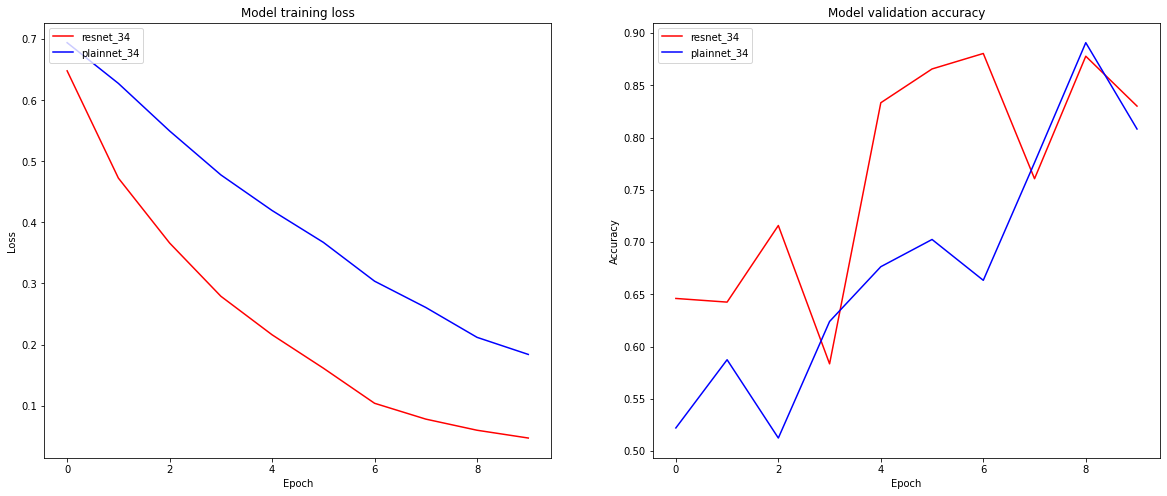

In [27]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

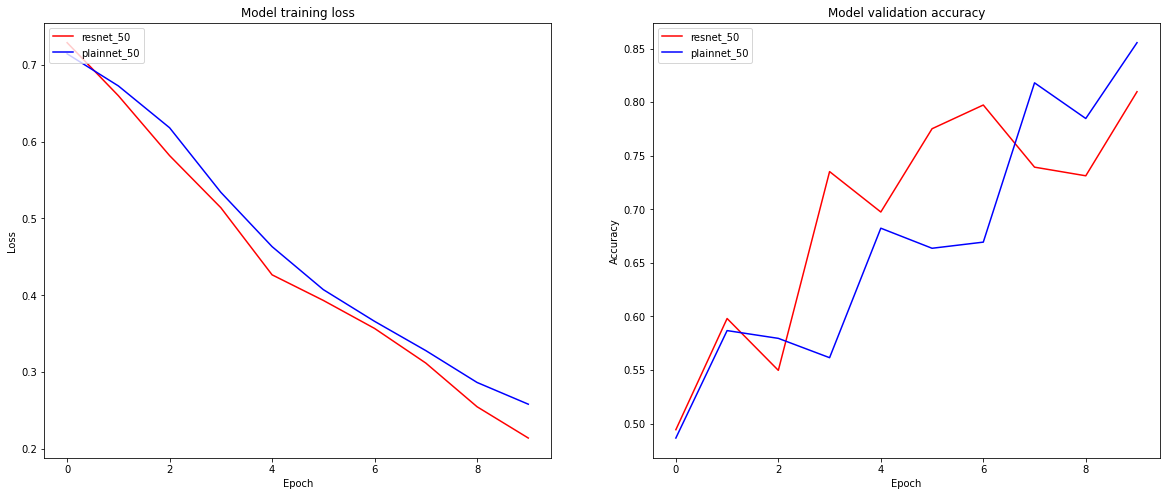

In [28]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

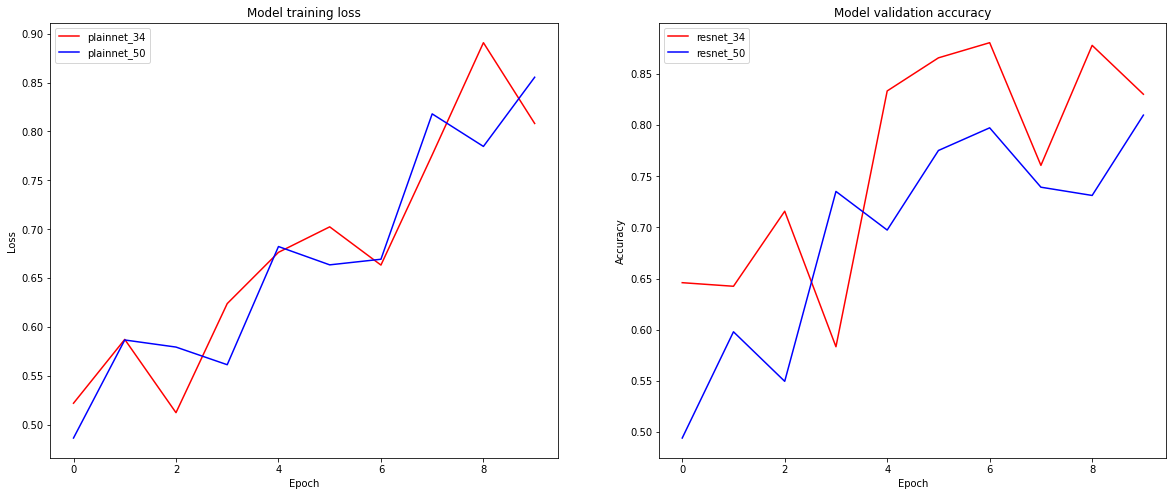

In [29]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plainnet_34', 'plainnet_50'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

# 결과 및 회고
- ResNet-34와 PlainNet-34 간의 결과는 제법 예상한 대로 나왔다. ResNet의 더 나은 training loss 결과와 대체로 더 높은 값의 validation set에 대한 accuracy를 확인할 수 있었다.
- ResNet-50과 PlainNet-50 간의 결과는 loss에서 큰 차이가 나지 않았지만 그래도 ResNet의 결과가 더 나았다. 하지만 valid_accuracy에서 막판에 완전히 역전된 결과가 나와 의아한 부분이 생겼다. 물론 매우 적은 epoch 수로 나온 결과를 통해 단정 짓기에는 무리가 있다.
- 각각의 PlainNet, ResNet끼리 비교한 결과에서는 레이어가 deep해질수록 더 나은 결과가 나올 것이라는 예상과는 다른 결과를 보여주었다.(이 또한, epoch 수가 너무 적기는 하다.)

#### 생각해 볼 부분들
- optimizer의 하이퍼 파라미터가 큰 영향을 주는가?
- adam을 사용했을 경우가 더 좋을 것으로 예상된다.
- BN과 ReLU 등의 위치에 대한 고민.

고생을 정말 많이 했던 첫 GoingDeeper project였다. 결국에는 100% 혼자의 힘으로 해내지 못한 점이 아쉽지만, 논문를 자세하게 살펴보고 수많은 참고자료들을 통해 가장 논문에 근접할 수 있도록 레이어, 구조, 각종 파라미터들을 세세하게 조정하며 ResNet을 구현하였다. 코딩 능력이 아직 많이 부족하단 것을 다시 한번 깨달았고, 논문을 보며 모델을 구현하는 것이 정말 어렵다는 것을 뼈저리게 느꼈다. 수행을 한다는 마음으로 이번 프로젝트를 임했고, 앞으로 어떤 공부를 더 하면 좋을지에 대해 정리할 수 있는 시간이었다.
동료들과 GAN을 이용한 프로젝트를 하기 위해 구상 중인데, 이를 위해 더욱 정진하여 마지막까지 멋지게 마무리 짓고 싶다.

# 참고자료
<Deep Residual Learning for Image Recognition> helighted by me:
https://drive.google.com/file/d/1qgF2v3zk4BTO5DyiunPekfw-iFlR5Zao/view?usp=sharing

ResNet34 구현 결과(Summary):
https://drive.google.com/file/d/1_EkQWJaA_Lq53PXP3VkPhdaBzVbR0YUi/view?usp=sharing

ResNet 도식화
http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

ResNet 구조 이해 - <준세 단칸방>
https://wjunsea.tistory.com/99

컨볼루션 신경망 레이어 이야기
https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/

CNN에서 필터 설계시 유용한 공식들
http://www.kwangsiklee.com/2018/10/cnn%EC%97%90%EC%84%9C-%ED%95%84%ED%84%B0-%EC%84%A4%EA%B3%84%EC%8B%9C-%EC%9C%A0%EC%9A%A9%ED%95%9C-%EC%88%98%ED%95%99%EA%B3%B5%EC%8B%9D/

[DL] LeNet-5, AlexNet, VGG-16, ResNet, Inception Network
https://wooono.tistory.com/233

Training and investigating Residual Nets
http://torch.ch/blog/2016/02/04/resnets.html

[논문 읽기] Pre-Activation ResNet(2016) 리뷰, Identity Mappings in Deep Residual Networks
https://deep-learning-study.tistory.com/510

[논문리뷰] ResNet(pytorch로 구현)
https://visionhong.tistory.com/7

ResNet(Residual Connection)
https://itrepo.tistory.com/36

### ResNet(is_plain 포함) - 수정필요.

In [ ]:
#@title
# function for building ResNet Block
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection 
# 3x3 커널, 64채널 2층
# padding = 'same'은 output이 Math.ceil(input_size / stride)와 동일.

# def build_resnet_block(input_layer,
#                     num_cnn=3, 
#                     channel=64,
#                     block_num=1,
#                     is_50 = False,
#                     # is_plain = False,
#                    ):
#     # 입력 레이어
#     x = input_layer
#     if not is_50:
#     # CNN 레이어
#       for cnn_num in range(num_cnn):
#           identity = x 
#           # if channel == 64:
#           #     x = Conv2D(
#           #         filters=channel,
#           #         kernel_size=(3,3),
#           #         activation='relu',
#           #         kernel_initializer='he_normal',
#           #         padding='same',
#           #         name=f'block{block_num}_conv{cnn_num}'
#           #         )(x)
#           # else:
#           #     x = ZeroPadding2D(padding=(1,1))(x)
#           #     x = Conv2D(
#           #         filters=channel,
#           #         kernel_size=(3,3),
#           #         strides=(2,2),
#           #         activation='relu',
#           #         kernel_initializer='he_normal',
#           #         padding='valid',
#           #         name=f'block{block_num}_conv{cnn_num}',
#           #         )(x)
#           # if not is_plain:
#           identity_channel = identity.shape.as_list()[-1]

#           if identity_channel != channel:
#                   x = ZeroPadding2D(padding=(1,1))(x)
#                   x = Conv2D(
#                       filters=channel,
#                       kernel_size=(3,3),
#                       strides=(2,2),
#                       activation='relu',
#                       kernel_initializer='he_normal',
#                       padding='valid',
#                       name=f'block{block_num}_conv{cnn_num}',
#                       )(x)
#                   x = BatchNormalization()(x)
#                   x = Conv2D(
#                       filters=channel,
#                       kernel_size=(3,3),
#                       activation='relu',
#                       kernel_initializer='he_normal',
#                       padding='same',
#                       name=f'block{block_num}_1_conv{cnn_num}',
#                   )(x)
#                   x = Add()(x)

#           else:
#                   x = Conv2D(
#                       filters=channel,
#                       kernel_size=(3,3),
#                       activation='relu',
#                       kernel_initializer='he_normal',
#                       padding='same',
#                       name=f'block{block_num}_conv{cnn_num}'
#                   )(x)
#                   x = BatchNormalization()(x)
#                   x = Conv2D(
#                       filters=channel,
#                       kernel_size=(3,3),
#                       activation='relu',
#                       kernel_initializer='he_normal',
#                       padding='same',
#                       name=f'block{block_num}_1_conv{cnn_num}',
#                   )(x) 

#                   identity = Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='same')(identity)
#                   x = Add()([x,identity]) # ex) 64+64 = 128

#           # if not is_plain:
#           #     identity_channel = identity.shape.as_list()[-1] # ex) input : (3,3,64) 마지막이 채널 수를 나타내기 때문에.
          
              
                
#           # else:
#           #     pass


#     else:
#       identity = x
#       x = Conv2D(
#           filters=channel,
#           kernel_size=(1,1),
#           activation='relu',
#           kernel_initializer='he_normal',
#           padding='same',
#           name=f'block{block_num}_conv{cnn_num}'
#       )(x)
#       x = BatchNormalization()(x)
#       x = Conv2D(
#           filters=channel,
#           kernel_size=(3,3),
#           activation='relu',
#           kernel_initializer='he_normal',
#           padding='same',
#           name=f'block{block_num}_1_conv{cnn_num}'          
#       )(x)
#       x = BatchNormalization()(x)
#       x = Conv2D(
#           filters=channel*4,
#           kernel_size=(1,1),
#           activation='relu',
#           kernel_initializer='he_normal',
#           padding='same',
#           name=f'block{block_num}_2_conv{cnn_num}',
#       )(x)
#       # if not is_plain:
#       identity_channel = identity.shape.as_list()[-1] 
      
#       if identity_channel != channel:
#         identity = Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='same')(identity)
#         x = Add()([x,identity])
#         x = layers.Activation(activations.relu)(x)
#       else:
#         pass

#     return x
#@title

- ResNet 34와 50은 3-4-6-3 순서의 동일한 블록 구조를 갖고 있다.
- 채널의 크기 또한 해당 층마다 64-128-256-512로 동일하나 50의 경우 마지막에 4배로 커졌다가 줄어든다.
#@title
# def build_resnet(input_shape=(32,32,3),
#               num_cnn_list=[3,4,6,3],
#               channel_list=[64,128,256,512],
#               num_classes=10,is_50 = False, is_plain = False):
    
#     assert len(num_cnn_list) == len(channel_list) #num_cnn_list 와 channel_list의 짝이 맞는지 확인해주는 코드로서 추가.

#     if is_50:
#         num_cnn_list = [3,4,6,3]
#         channel_list = [64,128,256,512]
#         num_classes = 10
        
#     input_layer = Input(shape=input_shape)  # input layer를 만들어둡니다.32
#     output = input_layer
#     #conv1층
#     output = ZeroPadding2D(padding=(1,1))(output)#34
#     output = Conv2D(filters=64,
#                        kernel_size = (3,3),#31
#                        strides = (2, 2),#15+1
#                        padding = 'valid')(output)
#     output = BatchNormalization()(output)
    
#     #conv2_x pooling
#     output = ZeroPadding2D(padding=(1,1))(output)
#     output = MaxPooling2D(pool_size = (3,3),
#                                       strides = 2,)(output)    
#     # config list들의 길이만큼 반복해서 블록을 생성합니다.
#     for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
#         output = build_resnet_block(
#             output,
#             num_cnn=num_cnn, 
#             channel=channel,
#             block_num=i
#             )    
#     output = GlobalAveragePooling2D()(output)
#     output = Flatten(name='flatten')(output)
#     output = Dense(1000, activation='relu', name='fc1')(output) # 선택사항으로 생각함. 바로 Dense10일 경우 
#     output = Dense(num_classes, activation='softmax', name='predictions')(output)
    
#     model = keras.Model(
#         inputs=input_layer, 
#         outputs=output
#     )
#     return model
#@title
# resnet_34 = build_resnet(is_50 = False)
# resnet_50 = build_resnet(is_50 = True)
# plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
# plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)
#@title
# resnet_34.summary()
#@title
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
# def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
#     # 입력 레이어
#     x = input_layer
#     if not is_50:
#     # CNN 레이어
#         for cnn_num in range(num_cnn):
#             identity = x
#             x = keras.layers.Conv2D(
#                 filters=channel,
#                 kernel_size=(3,3),
#                 activation='relu',
#                 kernel_initializer='he_normal',
#                 padding='same',
#                 name=f'block{block_num}_conv{cnn_num}'
#             )(x)
#             x = keras.layers.BatchNormalization()(x)
#             x = keras.layers.Conv2D(
#                 filters=channel,
#                 kernel_size=(3,3),
#                 activation='relu',
#                 kernel_initializer='he_normal',
#                 padding='same',
#                 name=f'block{block_num}_1_conv{cnn_num}'
#             )(x)
#             if not is_plain:
#                 identity_channel = identity.shape.as_list()[-1]    

#                 if identity_channel != channel:
#                     identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
#                 # skip connection
#                 x = keras.layers.Add()([x,identity])   
#             else:
#                 pass
#     else :
#         identity = x
#         x = keras.layers.Conv2D(
#             filters=channel,
#             kernel_size=(1,1),
#             activation='relu',
#             kernel_initializer='he_normal',
#             padding='same',
#             name=f'block{block_num}_conv{cnn_num}'
#         )(x)
#         x = keras.layers.BatchNormalization()(x)
#         x = keras.layers.Conv2D(
#             filters=channel,
#             kernel_size=(3,3),
#             activation='relu',
#             kernel_initializer='he_normal',
#             padding='same',
#             name=f'block{block_num}_1_conv{cnn_num}'
#         )(x)
#         x = keras.layers.Conv2D(
#             filters=channel * 4,
#             kernel_size=(1,1),
#             activation='relu',
#             kernel_initializer='he_normal',
#             padding='same',
#             name=f'block{block_num}_2_conv{cnn_num}'
#         )(x)
#         if not is_plain:
#             identity_channel = identity.shape.as_list()[-1]    

#             if identity_channel != channel:
#                 identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
#             # skip connection
#             x = keras.layers.Add()([x,identity])   
#         else:
#             pass
#     #     Max Pooling 레이어
#     # 마지막 블록 뒤에는 pooling을 하지 않음
#     if identity.shape[1] != 1:        
#         x = keras.layers.MaxPooling2D(
#             pool_size=(2, 2),
#             strides=2,
#             name=f'block{block_num}_pooling'
#         )(x)

#     return x
#@title
# def build_resnet(input_shape=(32,32,3),
#               num_cnn_list=[3,4,6,3],
#               channel_list=[64,128,256,512],
#               num_classes=10,is_50 = False, is_plain = False):
    
#     assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
#     if is_50:
#         num_cnn_list = [3,4,6,3]
#         channel_list = [64,128,256,512]
#         num_classes = 10
        
#     input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
#     output = input_layer
#     #conv1층
#     output = keras.layers.Conv2D(filters=64,
#                        kernel_size = (2,2),
#                        strides = 2,
#                          padding = 'valid')(output)
#     output = keras.layers.BatchNormalization()(output)
    
#     #conv2_x pooling
#     output = keras.layers.MaxPooling2D(pool_size = (2,2),
#                                       strides = 2,)(output)    
#     # config list들의 길이만큼 반복해서 블록을 생성합니다.
#     for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
#         output = build_resnet_block(
#             output,
#             num_cnn=num_cnn, 
#             channel=channel,
#             block_num=i
#         )    
#     output = keras.layers.AveragePooling2D(padding = 'same')(output)
#     output = keras.layers.Flatten(name='flatten')(output)
#     output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
#     output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
#     model = keras.Model(
#         inputs=input_layer, 
#         outputs=output
#     )
#     return model
#@title
# resnet_34 = build_resnet(is_50 = False)
# resnet_50 = build_resnet(is_50 = True)
# plain_resnet_34 = build_resnet(is_50 = False, is_plain = True)
# plain_resnet_50 = build_resnet(is_50 = True, is_plain = True)
#@title
# resnet_34.summary()

---
# VGG로 연습하기.

In [ ]:
pip list | grep tensorflow-datasets

tensorflow-datasets           4.0.1


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir = '/content/drive/MyDrive/aiffel/data'
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/drive/MyDrive/aiffel/data/cifar10/3.0.2.incompleteY0UHVD/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/drive/MyDrive/aiffel/data/cifar10/3.0.2.incompleteY0UHVD/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /content/drive/MyDrive/aiffel/data/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


## Input Normalization

Data normalization은 데이터 범위를 원하는 범위로 제한함. 예를 들어 0-255의 픽셀 정보를 갖는 이미지 데이터를 255로 나누어 0-1.0 사이의 값을 가지게 하는 작업이다. 머신러닝에서 이를 하는 이유는 scale이 큰 feature에 대한 영향이 비대해지는 것을 방지하고, 딥러닝에서는 local optimum에 빠질 위험을 줄여 학습 속도를 향상시킨다.

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_info.features["label"].num_classes

10

In [ ]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

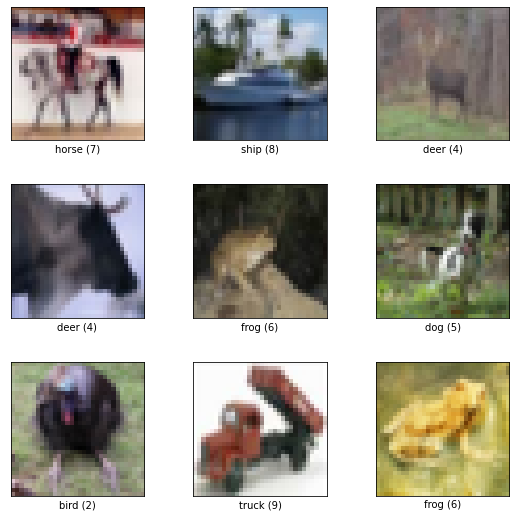

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

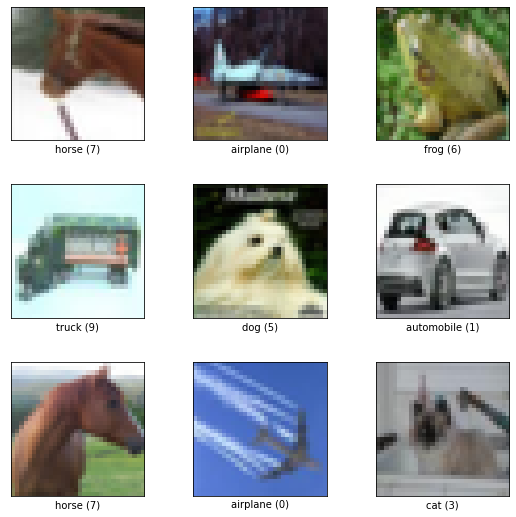

In [ ]:
fig = tfds.show_examples(ds_test, ds_info)

## Ablation Study
블록 구성하기

In [ ]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [ ]:
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

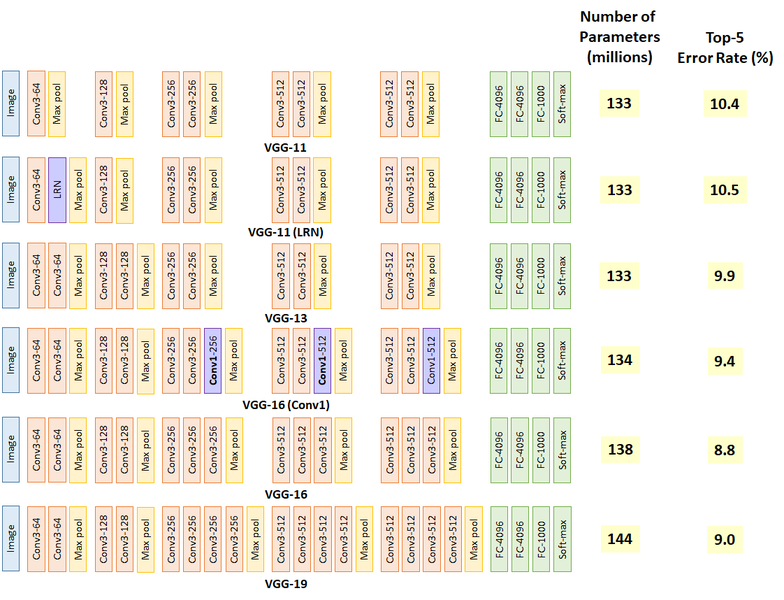

VGG - 16 과 VGG - 19 만들기

In [ ]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                             

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)


vgg_19.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

## VGG16 vs VGG19
두 모델의 성능 비교하기.

In [ ]:
BATCH_SIZE = 256
EPOCH = 15

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteI52ISG/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteI52ISG/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 45s 131ms/step - loss: 2.1834 - accuracy: 0.1899 - val_loss: 2.0792 - val_accuracy: 0.2192
Epoch 2/15
195/195 [==============================] - 23s 118ms/step - loss: 1.9848 - accuracy: 0.2794 - val_loss: 2.0089 - val_accuracy: 0.2898
Epoch 3/15
195/195 [==============================] - 24s 122ms/step - loss: 1.8468 - accuracy: 0.3374 - val_loss: 1.7992 - val_accuracy: 0.3602
Epoch 4/15
195/195 [==============================] - 24s 121ms/step - loss: 1.7383 - accuracy: 0.3755 - val_loss: 1.6680 - val_accuracy: 0.4186
Epoch 5/15
195/195 [==============================] - 24s 121ms/step - loss: 1.6569 - accuracy: 0.4030 - val_loss: 1.6292 - val_accuracy: 0.4283
Epoch 6/15
195/195 [==============================] - 24s 121ms/step - loss: 1.5903 - accuracy: 0.4274 - val_loss: 1.5402 - val_accuracy: 0.4539
Epoch 7/15
195/195 [==============================] - 24s 121ms/step - loss: 1.5312 - accuracy: 0.4508 - val_loss: 1.5042 - val_accuracy: 0.4

In [ ]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 32s 145ms/step - loss: 2.2151 - accuracy: 0.1713 - val_loss: 2.1208 - val_accuracy: 0.2148
Epoch 2/15
195/195 [==============================] - 28s 143ms/step - loss: 2.0432 - accuracy: 0.2505 - val_loss: 1.9760 - val_accuracy: 0.2936
Epoch 3/15
195/195 [==============================] - 28s 142ms/step - loss: 1.9176 - accuracy: 0.3029 - val_loss: 1.8256 - val_accuracy: 0.3502
Epoch 4/15
195/195 [==============================] - 28s 142ms/step - loss: 1.7953 - accuracy: 0.3516 - val_loss: 1.7022 - val_accuracy: 0.3836
Epoch 5/15
195/195 [==============================] - 28s 143ms/step - loss: 1.6938 - accuracy: 0.3858 - val_loss: 1.6137 - val_accuracy: 0.4242
Epoch 6/15
195/195 [==============================] - 28s 144ms/step - loss: 1.6295 - accuracy: 0.4124 - val_loss: 1.5976 - val_accuracy: 0.4317
Epoch 7/15
195/195 [==============================] - 28s 142ms/step - loss: 1.5653 - accuracy: 0.4347 - val_loss: 1.5081 - val_accuracy: 0.4

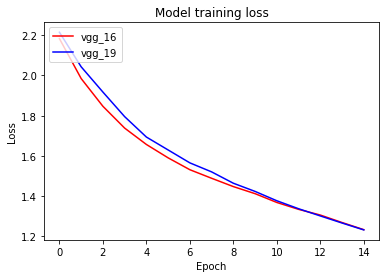

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

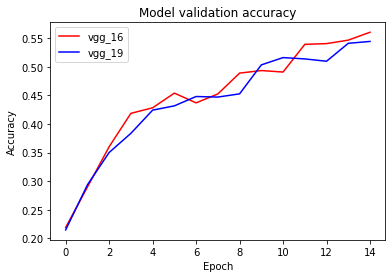

In [ ]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()